In [17]:
import os
os.environ['DISPLAY'] = "localhost:12.0" #linux env variable for ase gui
from ase.build import nanotube
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np

1. calculate the radius of CNT

In [18]:
cnt_dict = {}
for i in range (6,7):
    cnt_dict[f'{i}-{i}'] = nanotube(i, i, length = 10, bond=1.42, verbose=True,vacuum=10.0)  # length是六元环的长度，bond是C-C键长



the symmetry vector is 1 0
radius= 4.068000345428845 2.4595121467478056
translation vector = 2.4595121467478056
diameter =  8.13600069085769
chiral angle =  30.0


In [19]:
import numpy as np
from ase import Atoms

def group_atoms_by_z(atoms, decimal=3, atol=0.01, verbose=True):
    import numpy as np
    from ase import Atoms

    positions = atoms.get_positions()
    z = positions[:, 2]

    unique_z = np.unique(np.round(z, decimal))
    layers = {}
    layer_indices = {}

    for i, z_val in enumerate(unique_z):
        indices = np.where(np.isclose(z, z_val, atol=atol))[0]
        layers[i] = atoms[indices]
        layer_indices[i] = indices

        if verbose:
            print(f"Layer {i}: z ≈ {z_val:.3f} Å, atoms = {len(indices)}")

    return layers, layer_indices


def remove_layers_by_z(atoms, remove_layers=None, decimal=3, atol=0.01, verbose=True):
    import numpy as np
    from ase import Atoms

    layers, layer_indices = group_atoms_by_z(atoms, decimal=decimal, atol=atol, verbose=False)
    all_layers = sorted(layer_indices.keys())

    # 自动删除第一层和最后一层
    if remove_layers is None:
        raise ValueError("请提供要删除的层索引，例如 remove_layers=[0, 1] 或 'edge'")
    elif remove_layers == "edge":
        remove_layers = [all_layers[0], all_layers[-1]]

    # 保留未删除的索引
    keep_indices = [i for key, idx in layer_indices.items() if key not in remove_layers for i in idx]

    new_atoms = atoms[keep_indices]


    if verbose:
        print(f"删除层索引: {remove_layers}")
        print(f"原子数从 {len(atoms)} → {len(new_atoms)}")
        
    

    return new_atoms

In [20]:
for key, cnt in cnt_dict.items():
    cnt_new = remove_layers_by_z(cnt,remove_layers="edge")
    
    cnt_dict[key] = cnt_new 
    print(cnt)


删除层索引: [0, 20]
原子数从 240 → 228
Atoms(symbols='C240', pbc=[False, False, True], cell=[28.136000690857692, 28.136000690857692, 24.595121467478055])


In [21]:
## 增加间距

In [22]:

import numpy as np
from ase import Atoms

def add_vacuum_z_auto(atoms: Atoms, target_vacuum: float = 10.0, decimal: int = 3, atol: float = 0.01, verbose: bool = True):
    """
    自动在 z 方向补充真空层，使上下真空区域总和达到目标值（默认 10 Å）。

    参数：
        atoms (ase.Atoms): ASE 原子对象
        target_vacuum (float): 期望总真空层厚度（Å），默认 10 Å
        decimal (int): z 坐标取整精度（默认 3）
        atol (float): 层间容差
        verbose (bool): 是否打印调试信息

    返回：
        new_atoms (ase.Atoms): 添加真空后的新原子对象
    """
    from copy import deepcopy

    new_atoms = deepcopy(atoms)

    # 利用已有函数分层

    layers, layer_indices = group_atoms_by_z(new_atoms, decimal=decimal, atol=atol, verbose=False)
    all_layers = sorted(layer_indices.keys())

    if len(all_layers) < 2:
        raise ValueError("体系层数不足 2 层，无法计算真空层。")
    
     # 获取第一层和最后一层的原子 z 值
    first_layer_z = new_atoms.positions[layer_indices[all_layers[0]], 2]
    last_layer_z = new_atoms.positions[layer_indices[all_layers[-1]], 2]

    z_min = np.min(first_layer_z)
    z_max = np.max(last_layer_z)
    occupied_height = z_max - z_min  # 实际原子覆盖高度

    # 当前晶胞 z 尺寸
    cell = new_atoms.cell.cellpar()
    c_length = cell[2]
    vacuum_current = c_length - occupied_height  # 当前真空总厚度

    # 计算需要额外增加的真空
    delta_vacuum = target_vacuum - vacuum_current

    # 更新晶胞
    cell[2] = c_length + delta_vacuum
    new_atoms.set_cell(cell)
    new_atoms.center(axis=2)  # 沿 z 居中

    if verbose:
        print("----- 自动真空添加报告 -----")
        print(f"第一层 z_min = {z_min:.3f} Å，最后一层 z_max = {z_max:.3f} Å")
        print(f"原子层占据高度: {occupied_height:.3f} Å")
        print(f"当前晶胞高度: {c_length:.3f} Å")
        print(f"当前真空厚度: {vacuum_current:.3f} Å")
        print(f"目标真空厚度: {target_vacuum:.3f} Å")
        print(f"需要增加: Δc = {delta_vacuum:.3f} Å")
        print(f"新晶胞 c = {cell[2]:.3f} Å")
        print("-----------------------------")

    return new_atoms

In [23]:
import numpy as np
from ase import Atoms

for key, cnt in cnt_dict.items():
    cnt_new = add_vacuum_z_auto(cnt,10)
    cnt_dict[key] = cnt_new 
    print(cnt)


----- 自动真空添加报告 -----
第一层 z_min = 1.230 Å，最后一层 z_max = 23.365 Å
原子层占据高度: 22.136 Å
当前晶胞高度: 24.595 Å
当前真空厚度: 2.460 Å
目标真空厚度: 10.000 Å
需要增加: Δc = 7.540 Å
新晶胞 c = 32.136 Å
-----------------------------
Atoms(symbols='C228', pbc=[False, False, True], cell=[28.136000690857692, 28.136000690857692, 24.595121467478055])


In [25]:
#generate pdb file
from ase.build import molecule
molecule('H2O', vacuum=3.0).write('H2O.pdb')

for i in cnt_dict.items():
    i[1].write(f'{i[0]}_lim.pdb')
    print(f'{i[0]}_lim.pdb')

6-6_lim.pdb


In [26]:
def fit_circle(x, y):
    
    def calc_R(xc, yc):
        return np.sqrt((x-xc)**2 + (y-yc)**2)

    def f_2(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()
    
    from scipy.optimize import leastsq   
    center_estimate = x.mean(), y.mean()
    center_2, iter = leastsq(f_2, center_estimate)

    xc_2, yc_2 = center_2
    Ri_2       = calc_R(xc_2, yc_2)
    R_2        = Ri_2.mean()
    residu_2   = sum((Ri_2 - R_2)**2)
    # residu2_2  = sum((Ri_2**2-R_2**2)**2)
    return (xc_2, yc_2), R_2, residu_2

/tmp/ipykernel_728606/2038389135.py:10: RuntimeWarning: invalid value encountered in sqrt
  y_fit = np.sqrt(r**2 - (x_fit - center[0])**2) + center[1]
/tmp/ipykernel_728606/2038389135.py:11: RuntimeWarning: invalid value encountered in sqrt
  y_fit1 = -np.sqrt(r**2 - (x_fit - center[0])**2) + center[1]


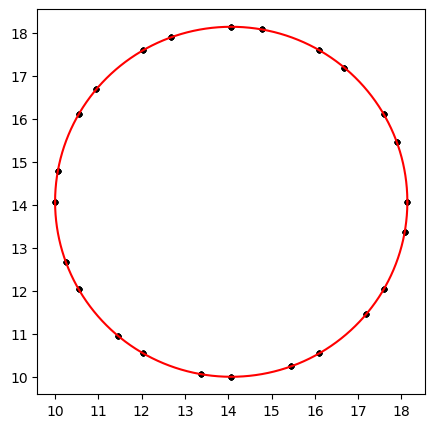

In [27]:
#test the fitting performance
x = cnt_dict['6-6'].get_positions()[:,0]
y = cnt_dict['6-6'].get_positions()[:,1]

plt.figure(figsize=(5,5))
plt.plot(x, y, '.', color='black')

center, r, residu = fit_circle(x, y)
x_fit = np.linspace(x.min(), x.max(), 1000000)
y_fit = np.sqrt(r**2 - (x_fit - center[0])**2) + center[1]
y_fit1 = -np.sqrt(r**2 - (x_fit - center[0])**2) + center[1]
plt.plot(x_fit, y_fit, '-', c='r')
plt.plot(x_fit, y_fit1, '-', c='r')

In [28]:
from ase.data import vdw_radii
c_vdw_r = vdw_radii[6]
print(c_vdw_r)

cnt_dict_fit = {}
for i in cnt_dict.keys():
    x = cnt_dict[i].get_positions()[:,0]
    y = cnt_dict[i].get_positions()[:,1]
    center, r, residu = fit_circle(x, y)
    cnt_dict_fit[i] = [*center, r, residu]
    



1.7


2.calculate the water numbers of different CNT with different water densities.

In [29]:
def calc_volume(r:float, l:float):
    """_summary_

    Args:
        r (float): radius of the nanotube
        l (float): length of the nanotube

    Returns:
        _type_: volume
    """
    return np.pi * r**2 * l

def get_n_water(v:float, d:float):
    """_summary_

    Args:
        v (float): volume of the nanotube, unit: A^3.
        d (float): density of the filling water, unit: g/cm^3.

    Returns:
        _type_: number of water molecules
    """
    m0 = 1.008*2 + 15.999
    NA = 6.022140857e23
    u_a_cm = 1e-8 #1 A = 10^-8 cm
    
    n_water =  d * v * u_a_cm**3 / (m0 / NA)

    return n_water

In [38]:
n_water_dict = {}
for i in cnt_dict_fit.keys():
    box_length = cnt_dict[i].cell.cellpar()[2]
    print(box_length)
    v = calc_volume(cnt_dict_fit[i][2], box_length)
    n_water_dict[i] = get_n_water(v, 1)
n_water_dict  

32.135609320730254


{'6-6': np.float64(55.84895055771626)}

In [31]:
v=  28.13600*28.13600*32.13600
get_n_water(v,1)

850.419426220627

3.fill water by Packmol

In [32]:
## 增加一个对于端部增加H原子

import numpy as np
from ase import Atom, Atoms


import numpy as np
from ase import Atom, Atoms

def add_h_by_angle_bisector(atoms: Atoms,
                            element: str = "C",
                            bond_length_CH: float = 1.09,
                            cc_bond_length: float = 1.42,
                            cc_tolerance: float = 0.05,
                            decimal: int = 3,
                            atol: float = 0.01,
                            axis: int = 2,
                            verbose: bool = True):
    """
    在纳米管或石墨烯边缘碳原子上添加氢，方向沿相邻C-C键的角平分线方向。
    每个端部碳只加一个氢。

    参数：
        atoms (ase.Atoms): 原子结构
        element (str): 要加氢的原子类型（默认 "C"）
        bond_length_CH (float): C–H 键长（Å），默认 1.09
        cc_bond_length (float): 理想 C–C 键长（Å）
        cc_tolerance (float): 邻碳判断误差（Å）
        decimal, atol: 用于分层参数
        axis (int): 分层方向 (z=2)
        verbose (bool): 打印信息

    返回：
        new_atoms (ase.Atoms): 添加氢后的新原子结构
    """
    from copy import deepcopy
    new_atoms = deepcopy(atoms)


    # 使用已有分层函数
    layers, layer_indices = group_atoms_by_z(new_atoms, decimal=decimal, atol=atol, verbose=False)
    all_layers = sorted(layer_indices.keys())
    bottom_layer, top_layer = all_layers[0], all_layers[-1]

    # 确保索引是整数列表
    bottom_indices = layer_indices[bottom_layer].tolist()
    top_indices = layer_indices[top_layer].tolist()
    # 只保留指定元素（C）
    bottom_indices = [i for i in bottom_indices if new_atoms[i].symbol == element]
    top_indices = [i for i in top_indices if new_atoms[i].symbol == element]

    positions = new_atoms.get_positions()
    H_atoms = []

    def find_neighbors_and_add_h(i_atom):
        """为单个端碳计算角平分线方向并添加H。"""
        pos_i = positions[i_atom]
        dists = np.linalg.norm(positions - pos_i, axis=1)
        neighbors = [
            j for j in range(len(new_atoms))
            if new_atoms[j].symbol == element
            and j != i_atom
            and abs(dists[j] - cc_bond_length) <= cc_tolerance
        ]
        if len(neighbors) < 2:
            if verbose:
                print(f"⚠️ 原子 {i_atom} 未找到足够邻居 ({len(neighbors)} 个)，跳过")
            return
        # 取两个最近的邻居
        if len(neighbors) > 2:
            neighbor_dists = dists[neighbors]
            neighbors = [x for _, x in sorted(zip(neighbor_dists, neighbors))[:2]]

        vec1 = pos_i - positions[neighbors[0]]
        vec2 = pos_i - positions[neighbors[1]]

        bis = vec1 / np.linalg.norm(vec1) + vec2 / np.linalg.norm(vec2)
        bis /= np.linalg.norm(bis)
        pos_H = pos_i + bis * bond_length_CH
        H_atoms.append(Atom("H", pos_H))
    
    for i in bottom_indices + top_indices:
        find_neighbors_and_add_h(i)
    
    for H in H_atoms:
        new_atoms.append(H)

    if verbose:
        print(f"✅ 已添加 H 原子 {len(H_atoms)} 个")
    return new_atoms        


In [33]:
cnt_H_dict = {}

for key, cnt in cnt_dict.items():
    cnt_new = add_h_by_angle_bisector(cnt)
    cnt_H_dict[key] = cnt_new 
    print(cnt_H_dict)


✅ 已添加 H 原子 24 个
{'6-6': Atoms(symbols='C228H24', pbc=[False, False, True], cell=[28.136000690857692, 28.136000690857692, 32.135609320730254])}


In [34]:
for i in cnt_H_dict.items():
    i[1].write(f'{i[0]}_lim_H.pdb')
    print(f'{i[0]}_lim_H.pdb')


6-6_lim_H.pdb


In [39]:
Packmol_path = '/raid/hwding/anaconda3/envs/gpumd/bin/packmol'

def gen_packmol_inf(cnt_pdb, density, r_fit):
    from ase import io
    from random import randint
    tag = randint(0,10000)
   
    cnt = io.read(cnt_pdb)
    cnt_type = cnt_pdb.split('.')[0]
    cell = cnt.cell.cellpar()
    a, b, c = cell[:3]

    # ====== Step . 计算内外区域体积 ======#
    V_total = a * b * c
    V_inner = calc_volume(r_fit, c)
    V_outer = V_total - calc_volume(r_fit ,c)
    n_water_in = round(get_n_water(V_inner, density))
    n_water_out = round(get_n_water(V_outer, density))
    n_water_all = round(get_n_water(V_total, density))
    print(n_water_in)
    print(n_water_out)
    ret = f'''tolerance 2.0
    output {cnt_type}-d-{density}.pdb
    structure {cnt_type}.pdb
      number 1
      center
      fixed {cell[0]/2} {cell[1]/2} {cell[2]/2} 0 0 0
    end structure


    structure H2O.pdb #need change to your system
      number  {n_water_out+45}
      inside box 2 2 2 {cell[0]-0.5} {cell[1]-0.5} {cell[2]-0.5}
      outside cylinder {cell[0]/2} {cell[1]/2} 1 0 0 1 {r_fit+1.0} {cell[2]-1} 
    end structure
    
    structure H2O.pdb #need change to your system
      number  {n_water_in-45}
      inside cylinder {cell[0]/2} {cell[1]/2} 2 0 0 1 {r_fit-1.5} {cell[2]-2}   
    
    end structure
'''
    inp_file = f'packmol-{cnt_type.split("/")[-1]}-{tag}.inp'
    with open(inp_file, 'w') as f_:
        f_.write(ret)
    return inp_file

def run_packmol(inp_file):
    from os import popen
    ret_mag = popen(f'{Packmol_path} < {inp_file}').read()
    if not 'Success!' in ret_mag:
        print (ret_mag)
        raise Exception(f'Packmol failed: {inp_file}')
    else:
        print (f'Packmol finished: {inp_file}')
    return None

def solvate_cnt(cnt_pdb, density, r_fit):
#only support when alpha=beta=gamma=90
    inp_file = gen_packmol_inf(cnt_pdb, density, r_fit)
    run_packmol(inp_file)
    
    from ase import io
    # cnt_solv = io.read(f'{cnt_pdb.split(".")[0]}-d-{density}.pdb')
    cnt = io.read(cnt_pdb)
    cell_vect = cnt.cell.cellpar()
    with open (f'{cnt_pdb.split(".")[0]}-d-{density}.pdb', 'r') as f_:
        lines = f_.readlines()
        lines[4] = f'CRYST1{cell_vect[0]:>9}{cell_vect[1]:>9}{cell_vect[2]:>9}\
{cell_vect[3]:>7}{cell_vect[4]:>7}{cell_vect[5]:>7}\n'
    with open (f'{cnt_pdb.split(".")[0]}-d-{density}_all.pdb', 'w') as f_:
        f_.writelines(lines)
    
    # the following will remove the CONECT part of pdb file
    # cnt_solv.set_pbc([True, True, True])
    # cnt_solv.set_cell(cell_vect[0:3])
    # cnt_solv.center()
    # cnt_solv.write(f'{cnt_pdb.split(".")[0]}-d-{density}.pdb')
    
    from os import remove
    remove(inp_file)
    return None

In [40]:
os.chdir('/raid/hwding/model-build/model-build')

for i in cnt_dict_fit.items():
    solvate_cnt(f'{i[0]}_lim_H.pdb', 1.0, i[1][2])

import glob
# from vac_cnt.add_connect_part import add_connect_part
# _list = glob.glob("*-d*.pdb")
# for i in _list:
#     add_connect_part(i)
    
os.chdir('..')

56
795
Packmol finished: packmol-6-6_lim_H-286.inp


4.pre-optimize  

In [46]:
from ase.io import read, write
from ase.constraints import FixAtoms
os.chdir('/raid/hwding/model-build/model-build')
cnt_solv = read('6-6-d-0.5.pdb')
cnt_solv.set_constraint(FixAtoms(indices=[atom.index for atom in cnt_solv if atom.symbol == 'C']))
# cnt_solv._get_constraints()

- method1: xtb  
can not optimze to the right state

In [7]:
# from xtb.ase.calculator import XTB
# cnt_solv.calc = XTB(method = 'GFN1-xTB', max_iterations=250)
# os.environ['OMP_NUM_THREADS'] = '12'
# os.environ['OMP_STACKSIZE'] = '30G'
# from ase.optimize.bfgs import BFGS
# BFGS(cnt_solv).run(fmax = 0.5)
# cnt_solv.write('6-6-d-1-xtb.pdb')

- method2: cp2k  
can not optimze to the right state

In [4]:
os.environ['CP2K_DATA_DIR'] = ''
cp2k_command = 'pwd_path=`pwd`; ssh node5 "cd ${pwd_path}; module load singularity/singularityCE_3.10.0;\
module load intel/impi/2018.4.274;\
mpirun -np 96 singularity exec --bind $PWD /home/kwwan/software/singularity/cp2k22_01.sif cp2k_shell.psmp"'

# cp2k_command = 'pwd_path=`pwd`;ssh node5 "cd ${pwd_path};module load gcc/9.3.0;\
# source /opt/intel/compilers_and_libraries_2018.5.274/linux/mkl/bin/mklvars.sh intel64;\
# source /home/kwwan/software/cp2k-7.1/cp2k-7.1/tools/toolchain/install/setup;\
# export PATH=$PATH:/home/kwwan/software/cp2k-7.1/cp2k-7.1/exe/local;\
# mpirun -n 96 cp2k_shell.popt"'
# os.environ['CP2K_DATA_DIR'] = '/home/kwwan/software/cp2k-7.1/cp2k-7.1/data'
os.environ['ASE_CP2K_COMMAND'] = cp2k_command
cp2k_command

'pwd_path=`pwd`; ssh node5 "cd ${pwd_path}; module load singularity/singularityCE_3.10.0;module load intel/impi/2018.4.274;mpirun -np 96 singularity exec --bind $PWD /home/kwwan/software/singularity/cp2k22_01.sif cp2k_shell.psmp"'

In [29]:
# from ase.calculators.cp2k import CP2K
# cnt_solv.set_calculator(CP2K())
# from ase.optimize.bfgs import BFGS
# BFGS(cnt_solv).run(fmax = 0.5)
# cnt_solv.write('6-6-d-1-cp2k.pdb')

- method3: vasp  
can not optimze to the right state

In [48]:
from glob import glob
cnt_pdb_list = glob('*-*-d-*.pdb')

In [49]:
path = '/home/kwwan/work/cnt/model-build/vasp-opt'
for i in cnt_pdb_list:
    tag = '.'.join(i.split('.')[:-1])
    if not os.path.exists(f'{path}/{tag}'):
        os.mkdir(f'{path}/{tag}')
    tmp = read(i)
    tmp.set_constraint(FixAtoms(indices=[atom.index for atom in tmp if atom.symbol == 'C']))
    tmp.write(f'{path}/{tag}/POSCAR', format='vasp', sort=True)

FileNotFoundError: [Errno 2] No such file or directory: '/home/kwwan/work/cnt/model-build/vasp-opt/11-11-d-0.5'

- 2 step method  
(1)lammps pre-opt

In [50]:
from gen_lmp_data.gen_lmp_data_vmd import gen_lmp_data
from glob import glob

_list = glob('/raid/hwding/cp2k/lmp-pre/*-d*.pdb')
for i in _list:
    gen_lmp_data(i)

/raid/hwding/anaconda3/envs/gpumd/lib/vmd/vmd_LINUXAMD64: /raid/hwding/anaconda3/envs/gpumd/lib/vmd/../libGL.so.1: no version information available (required by /raid/hwding/anaconda3/envs/gpumd/lib/vmd/vmd_LINUXAMD64)
/raid/hwding/anaconda3/envs/gpumd/lib/vmd/vmd_LINUXAMD64: /raid/hwding/anaconda3/envs/gpumd/lib/vmd/../libGL.so.1: no version information available (required by /raid/hwding/anaconda3/envs/gpumd/lib/vmd/vmd_LINUXAMD64)
/raid/hwding/anaconda3/envs/gpumd/lib/vmd/vmd_LINUXAMD64: /raid/hwding/anaconda3/envs/gpumd/lib/vmd/../libGL.so.1: no version information available (required by /raid/hwding/anaconda3/envs/gpumd/lib/vmd/vmd_LINUXAMD64)
/raid/hwding/anaconda3/envs/gpumd/lib/vmd/vmd_LINUXAMD64: /raid/hwding/anaconda3/envs/gpumd/lib/vmd/../libGL.so.1: no version information available (required by /raid/hwding/anaconda3/envs/gpumd/lib/vmd/vmd_LINUXAMD64)
/raid/hwding/anaconda3/envs/gpumd/lib/vmd/vmd_LINUXAMD64: /raid/hwding/anaconda3/envs/gpumd/lib/vmd/../libGL.so.1: no versio

In [51]:
_list = sorted(glob('/raid/hwding/cp2k/lmp-pre/*-d*.data'))
 
import os
for i in _list:
    i_ = '.'.join(i.split('/')[-1].split('.')[:-1])
    if not os.path.exists(f'/raid/hwding/cp2k/lmp-pre/{i_}'):
        os.mkdir(f'/raid/hwding/cp2k/lmp-pre/{i_}')
    os.system(f'cp {i} /raid/hwding/cp2k/lmp-pre//{i_}/lmp.data')
    os.system(f'ln -s ../input.lammps lmp-pre/{i_}')
    os.system(f'ln -s ../lmp.slurm2 lmp-pre/{i_}')

ln: failed to create symbolic link 'lmp-pre/6-6-d-0.5_inf-lmp': File exists
ln: failed to create symbolic link 'lmp-pre/6-6-d-0.5_inf-lmp': File exists
ln: failed to create symbolic link 'lmp-pre/6-6-d-1.0_lim-lmp': File exists
ln: failed to create symbolic link 'lmp-pre/6-6-d-1.0_lim-lmp': File exists
ln: failed to create symbolic link 'lmp-pre/6-6_lim_H-d-1.0_all-lmp': File exists
ln: failed to create symbolic link 'lmp-pre/6-6_lim_H-d-1.0_all-lmp': File exists
ln: failed to create symbolic link 'lmp-pre/6-6_lim_H-d-1.0_all_more-lmp': File exists
ln: failed to create symbolic link 'lmp-pre/water-d-1.0-lmp': File exists
ln: failed to create symbolic link 'lmp-pre/water-d-1.0-lmp': File exists


In [52]:
## test


path = '/raid/hwding/cp2k/lmp-pre/6-6_lim_H-d-1.0_all_more-lmp/lmp.data'

output_path = '/raid/hwding/cp2k/lmp-pre/6-6_lim_H-d-1.0_all_more-lmp/lmp_clean.data'


def process_lmp_bonds_angles(filepath: str, output_file: str):
    """
    读取 lmp.data 文件：
    1️⃣ 在 "Bonds" 与 "Angles" 之间的行：
        - 如果第二列==1 → 删除整行；
        - 如果第二列==2 → 保留，修改第二列为1；
        - 重新编号第一列，从1开始。
    2️⃣ 对 Angles 之后的行执行相同逻辑。
    3️⃣ 输出处理后的内容到新的 data 文件。
    """
    with open(filepath, 'r') as f:
        lines = f.readlines()

    # ---- 找到 “Bonds” 和 “Angles” 的行号 ----
    bonds_line, angles_line = None, None
    for i, line in enumerate(lines):
        if line.strip() == "Bonds":
            bonds_line = i
        elif line.strip() == "Angles":
            angles_line = i
            break

    if bonds_line is None or angles_line is None:
        raise ValueError("⚠️ 未找到 'Bonds' 或 'Angles' 段落。")

    # ---- 拆分文件内容 ----
    header = lines[:bonds_line + 1]
    bonds_block = lines[bonds_line + 1:angles_line]
    angles_block = lines[angles_line + 1:]

    def clean_block(block):
        """
        删除第二列==1的行；
        对保留的行（原第二列==2）：
            - 第二列改为1；
            - 第一列重新编号；
        返回新的数据段列表。
        """
        new_block = []
        counter = 1
        for line in block:
            if not line.strip():  # 跳过空行
                continue
            parts = line.split()
            if len(parts) < 2:
                continue
            try:
                type_id = int(parts[1])
            except ValueError:
                continue
            if type_id == 1:
                continue  # 删除
            elif type_id == 2:
                parts[0] = str(counter)       # 重新编号
                parts[1] = '1'                # 将第二列改为1
                counter += 1
                new_block.append(' '.join(parts) + '\n')
        return new_block

    # ---- 清理各段 ----
    new_bonds = clean_block(bonds_block)
    new_angles_header = [lines[angles_line]]  # 保留 "Angles"
    new_angles = clean_block(angles_block)

    # ---- 写出文件 ----
    with open(output_file, 'w') as f:
        f.writelines(header)
        f.writelines(new_bonds)
        f.writelines(new_angles_header)
        f.writelines(new_angles)

    print(f"✅ 已处理完毕并写出：{output_file}")
    print(f"  Bonds 段保留 {len(new_bonds)} 行，Angles 段保留 {len(new_angles)} 行。")


process_lmp_bonds_angles(path,output_path)



✅ 已处理完毕并写出：/raid/hwding/cp2k/lmp-pre/6-6_lim_H-d-1.0_all_more-lmp/lmp_clean.data
  Bonds 段保留 1702 行，Angles 段保留 851 行。


(2)cp2k opt

In [24]:
def gen_cp2k_input(file, work_dir):
    from ase.io import read
    traj = read(file, index=':')
    if file.split('/')[-1] == 'traj.dump':
        conv_dict = {1:'C', 2:'H', 3:'O'}
        traj[-1].set_chemical_symbols([conv_dict[i] for i in traj[-1].get_atomic_numbers()])
    traj[-1].write(f'{work_dir}/cp2k.cif')

    atom_type = traj[-1].get_chemical_symbols()
    atom_pos = traj[-1].get_positions()
    with open(f'{work_dir}/cp2k.xyz', 'w') as f:
        f.write(f'{len(atom_type)}\n\n')
        for i in range(0, len(atom_type)):
            f.write(f'{atom_type[i]:<8}{atom_pos[i,0]:<17}{atom_pos[i,1]:<17}{atom_pos[i,2]:<17}{i+1}\n')

    _list = traj[-1].get_chemical_symbols()
    ret = []
    for i in range(len(_list)):
        if _list[i] == 'C':
            if i > 1 and _list[i-1] == 'C':
                ret[-1] = f'..{i+1}'
            else:
                ret.append(f' {i+1}')
    return ''.join(ret)


In [29]:
from glob import glob
lmp_list = glob('/home/kwwan/work/cnt/model-build/lmp-pre-opt-6/*d-0.4*-lmp/traj.dump')

In [30]:
import os
work_dir = '/home/kwwan/work/cnt/aimd/1'
for i in lmp_list:
    tag = i.split('/')[-2].split('-lmp')[0]
    if not os.path.exists(f'{work_dir}/{tag}'):
        os.mkdir(f'{work_dir}/{tag}')
    # os.system(f'cp {work_dir}/cp2k.* {work_dir}/{tag}')
    # os.system(f'ln -s {work_dir}/{tag}/cp2k.inp {work_dir}/{tag}/inp.cp2k')
    fix_list = gen_cp2k_input(i, f'{work_dir}/{tag}')
    # os.system(f'sed -i "s/SET FIXEDLIST/SET FIXEDLIST {fix_list}/g" {work_dir}/{tag}/cp2k.inp')

5.test parameters  
CUTOFF:850 RELCUTOFF:70


6.cp2k aimd

In [5]:
work_dir = '/home/kwwan/work/cnt/model-build/aimd'
pdb_list = glob('/home/kwwan/work/cnt/model-build/cp2k-opt-6/*d-*/cp2k-pos-1-new.pdb')

In [11]:
# ! rm -rf !(cp2k.sh|cp2k.inp)
for i in pdb_list:
    tag = i.split('/')[-2].split('-lmp')[0]
    if not os.path.exists(f'{work_dir}/{tag}'):
        os.mkdir(f'{work_dir}/{tag}')
    fix_list = gen_cp2k_input(i, f'{work_dir}/{tag}')
    os.system(f'cp {work_dir}/cp2k.* {work_dir}/{tag}')
    os.system(f'ln -s {work_dir}/{tag}/cp2k.inp {work_dir}/{tag}/inp.cp2k')
    os.system(f'sed -i "s/SET FIXEDLIST/SET FIXEDLIST {fix_list}/g" {work_dir}/{tag}/cp2k.inp')